In [79]:
import csv
import networkx as nx
from itertools import combinations
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import pandas as pd
%matplotlib inline

## 1. Creación del Grafo
A partir del archivo de datos, genere el grafo de colaboraciones entre autores. Cuente el número de nodos y aristas. Haga una representación gráfica del grafo.

In [2]:
autores_por_paper = []
with open('data.csv', 'r') as f_input:
    reader = csv.reader(f_input)
    for row in reader:
        autores_por_paper.append([a.strip() for a in row[3].split('&')])

In [3]:
grafo = nx.Graph()

for paper in autores_por_paper:
    if len(paper) == 1:
        grafo.add_node(paper[0])
    else:
        for c in combinations(paper, 2):
            grafo.add_edge(c[0], c[1])
        

In [4]:
print('Cantidad de nodos: {}'.format(grafo.number_of_nodes()))
print('Cantidad de aristas: {}'.format(grafo.number_of_edges()))

Cantidad de nodos: 3998
Cantidad de aristas: 7880


Con subgraph (https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.Graph.subgraph.html) podemos pasar una lista de nodos para que nos devuelva el grafo inducido.

Ahora bien, dada la distribución del grafo, debemos obtener un 

Vamos a graficar una muestra del grafo, ya que tiene demasiados nodos como para graficar el grafo entero.

In [5]:
CANTIDAD_NODOS_SUBMUESTRA = 100

In [6]:
distribucion_grados = nx.degree_histogram(grafo)
proporciones = np.array(distribucion_grados) / grafo.number_of_nodes()
cantidad_autores_submuestra_por_grado = proporciones * CANTIDAD_NODOS_SUBMUESTRA

In [7]:
autores_por_grado = {}
for autor, grado in nx.degree(grafo):
    try:
        autores_por_grado[grado].append(autor)
    except KeyError:
        autores_por_grado[grado] = [autor]

In [8]:
autores_subgrafo = []
for grado, autores in autores_por_grado.items():
    muestra = np.random.choice(autores, int(cantidad_autores_submuestra_por_grado[grado]))
    autores_subgrafo.extend(muestra)

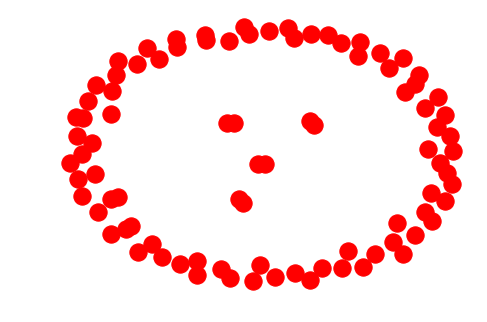

In [9]:
subgrafo_para_graficar = grafo.subgraph(autores_subgrafo)
nx.draw(subgrafo_para_graficar)


El subgrafo no es representativo del grafo. Al elegir nodos al azar, por más que respete las proporciones de grado en el grafo original, queda con un subgrafo inducido que no respeta PARA NADA esas proporciones. De hecho, queda un grafo casi sin aristas.

## Distribución del grafo
Grafique la distribución del grado de los autores, en escalas lineales, semilogarítmica, y log-log. Argumente, a partir de los gráficos, de qué tipo de distribución se trata.

### Distribución de grado de los autores
#### Lineal

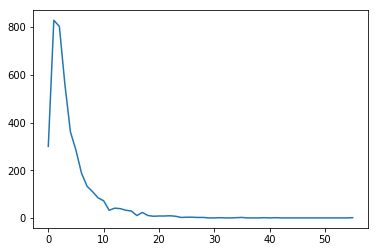

In [10]:
distribucion_grados = nx.degree_histogram(grafo)

plt.plot(range(len(distribucion_grados)), distribucion_grados)

### Semilogarítmica

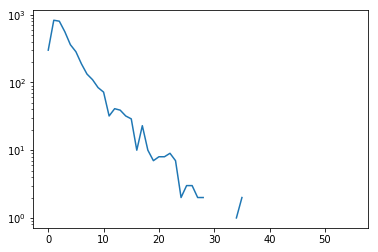

In [11]:
plt.semilogy(range(len(distribucion_grados)), distribucion_grados)

### Loglog

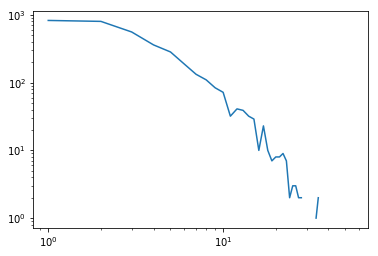

In [12]:
plt.loglog(range(len(distribucion_grados)), distribucion_grados)

Viendo los gráficos parece que lleva una distribución exponencial.

## Componentes Conexas

In [15]:
print("Cantidad de componentes conexas: {}".format(nx.number_connected_components(grafo)))

Cantidad de componentes conexas: 536


### Buscar el tamaño de la componente mayor

In [17]:
componentes = sorted(nx.connected_components(grafo), key = len, reverse=True)

for c in componentes[:5]:
    print(len(c))

3018
18
11
10
10


Como se ve, la componente de tamaño mayor es de 3018. La siguiente componente en tamaño es ordenes de magnitud mas chica como se ve al tomar las 5 más grandes.

In [18]:
tam_uno = 0
for c in componentes:
    if len(c) == 1:
        tam_uno += 1
print(tam_uno)

301


Además, podemos ver que 301 componentes son de tamaño uno. Es decir, que hay 301 autores que no comparten papers con otros.

## Tamaños de vecindades
Trabajando con la componente gigante del grafo, estudie, parándose en un nodo al azar, cómo aumenta el número de autores alcanzados a medida que se aleja del nodo semilla. Grafique el número de autores alcanzados en función de la distancia al nodo semilla. Grafique también el número de nuevos autores que se agregan en cada paso, y estime el máximo de esta función. Pruebe con varios nodos semillas y analice la robustez de este resultado. Discuta el significado de los gráficos y su relación con el fenómeno de seis grados de separación.

In [51]:
def tamaño_vecindades(G, nodo_semilla):
    '''G tiene que ser conexo'''
    if not nx.is_connected(G):
        raise ValueError
    s = set()
    s.add(nodo_semilla)
    while len(s) < G.number_of_nodes():
        iniciales = len(s)
        vecinos_iteracion = set()
        for n in s:
            for v in G.neighbors(n):
                vecinos_iteracion.add(v)
        s = s.union(vecinos_iteracion)
        yield len(s) - iniciales


In [85]:
componente_gigante = nx.Graph(grafo.subgraph(componentes[0]))

def datos_autores_por_distancia(componente_gigante, iteraciones):
    promedios = []
    for _ in range(iteraciones):
        nodo_semilla = random.choice(list(componente_gigante.nodes()))
        distancia = 0
        it = [0 for _ in range(16)]
        for i in tamaño_vecindades(componente_gigante, nodo_semilla):
            it[distancia] = i
            distancia += 1
        promedios.append(it)
    return promedios

### Gráfico de cantidad de nuevos autores que se agregan en cada paso

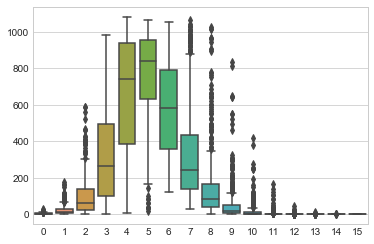

In [86]:
proms = datos_autores_por_distancia(componente_gigante, 500)
df = pd.DataFrame(proms)
sns.boxplot(data=df);

### Gráfico de cantidad de autores totales que se alcanzan a medida que aumenta la distancia al nodo semilla

In [91]:
promedio_nuevos_por_distancia = df.mean(axis=0)
acumulados = []
suma = 0
for i in promedio_nuevos_por_distancia:
    suma += i
    acumulados.append(suma)

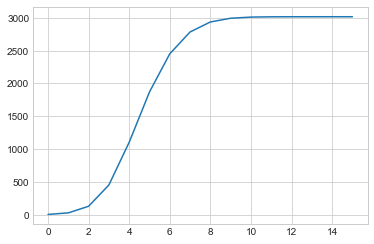

In [93]:
plt.plot(acumulados)

### ¿Seis? grados de separación

Como se desprende de los gráficos, no alcanza con seis grados de separación para alcanzar a **todos** los nodos del grafo. Sin embargo, sí se alcanza a un porcentaje muy grande del grafo (83% aprox.). En el boxplot se ve como en el grado seis ya baja la cantidad de autores nuevos que se agregan, ya que la mayoría de los que se agregan en ese paso, ya habían sido alcanzados.

## 5. Mundos Pequeños
Compute el coeficiente de clustering C y el camino mínimo medio _l_ para la componente gigante. Genere un grafo aleatorio con la misma distribución de grado y compute las mismas medidas para este grafo. Compare e interprete los resultados. ¿Se trata de un grafo con estructura de mundos pequeños?

In [107]:
def clustering_y_shortest_path(G):
    print("Coeficiente de clustering C: {}".format(nx.algorithms.cluster.average_clustering(G)))
    print("Camino mínimo medio: {}".format(nx.algorithms.shortest_paths.generic.average_shortest_path_length(G)))

In [104]:
clustering_y_shortest_path(componente_gigante)

Coeficiente de clustering C: 0.48400143699699166
Camino mínimo medio: 6.131037221593651


In [128]:
grados = [grado for autor,grado in nx.degree(componente_gigante)]

In [129]:
mundo_aleatorio = nx.generators.degree_seq.random_degree_sequence_graph(grados)

In [130]:
nx.number_connected_components(mundo_aleatorio)

11

In [131]:
componentes_mundo_aleatorio = sorted(nx.connected_components(mundo_aleatorio), key = len, reverse=True)

In [132]:
for c in componentes_mundo_aleatorio:
    print(len(c))

2997
3
2
2
2
2
2
2
2
2
2


In [142]:
## Nos quedamos solo con la componente gigante de esto.
componente_gigante_mundo_aleatorio = nx.Graph(mundo_aleatorio.subgraph(componentes_mundo_aleatorio[0]))

In [143]:
clustering_y_shortest_path(componente_gigante_mundo_aleatorio)

Coeficiente de clustering C: 0.00415094387844598
Camino mínimo medio: 4.732777726547197


Al generar el grafo de manera aleatoria, es mucho más dificil que se generen clusters. Por eso el coeficiente de clustering es muchísimo más bajo. El camino mínimo medio baja. No mucho, pero baja. Eso intuimos que es porque en un grafo de mundo pequeño hay algunos nodos destacados dentro de cada cluster que tienen muchas aristas que se comunican con otros clusters. En cambio, en un grafo aleatorio con bajo coeficiente de clustering, es más fácil encontrar aristas que conecten distintas "regiones" del grafo, lo cual termina bajando la distancia promedio entre nodos.

Claramente, el grafo generado aleatoriamente no presenta las propiedades de un "mundo pequeño".

## Estrellas

Una idea sencilla es tomar a los nodos con mayor grado. Probemos:

In [170]:
tuplas_estrellas_grados = sorted(nx.degree(componente_gigante), key = lambda x: x[1], reverse = True)
tuplas_estrellas_grados[:10]

[('Lee', 55),
 ('Ambjorn', 41),
 ('Kim', 39),
 ('Ferrara', 35),
 ('Park', 35),
 ('Vafa', 34),
 ('Strominger', 31),
 ('Gibbons', 28),
 ('Odintsov', 28),
 ('Pope', 27)]

In [147]:
closseness = nx.algorithms.centrality.closeness_centrality(componente_gigante)

In [172]:
tuplas_estrellas_closeness = sorted(closseness.items(), key = lambda x: x[1], reverse = True)
tuplas_estrellas_closeness[:10]

[('Lee', 0.24211540004815024),
 ('Vafa', 0.24182430266110932),
 ('Strominger', 0.23590585659551178),
 ('Ferrara', 0.23427550861935084),
 ('Park', 0.2335500851525004),
 ('Kim', 0.23331528884077024),
 ('Lu', 0.23327920822701617),
 ('Lowe', 0.2321840849622903),
 ('Polchinski', 0.23200553675792063),
 ('Peet', 0.23081631091729785)]

Computando el grado de cada autor, y la medida de centralidad por closseness, encontramos que Lee, Ferrara, Park y Kim muestran elevados indices de "estrellato" para ambas métricas. 

In [181]:
def quitar_hasta_romper(nodos, G):
    G_ = G.copy()
    c = 0
    for nodo in nodos:
        c += 1
        G_.remove_node(nodo)
        if not nx.is_connected(G_):
            return c
    return None

In [177]:
quitar_hasta_romper([c[0] for c in tuplas_estrellas_closeness], componente_gigante)

1

In [178]:
quitar_hasta_romper([c[0] for c in tuplas_estrellas_grados], componente_gigante)

1

Quitando a los autores estrella, en orden de 'estrellato', encontramos que quitar Lee al ser demasiado central alcanza para romper la conectividad del grafo. Probamos entonces sin tener en cuenta a Lee.

In [179]:
quitar_hasta_romper([c[0] for c in tuplas_estrellas_closeness][1:], componente_gigante)

4

In [180]:
quitar_hasta_romper([c[0] for c in tuplas_estrellas_grados][1:], componente_gigante)

2

Vemos que ignorando al componente de mayor métrica, la medida de grados pareciera computar mejor la importancia del autor, con la finalidad de romper el grafo, ya que con quitar los siguiente 2 componentes alcanza para romper el grafo, en contraste a los 4 requeridos siguiendo los puntajes de closeness. 